In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import yfinance as yf
import datetime as dt
import statsmodels.api as sm
import matplotlib.transforms as transforms
import scipy.stats as ss
from pandas_datareader import data as pdr
from scipy.stats import t, norm
from scipy import stats
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
!pip install pykalman
from pykalman import KalmanFilter, UnscentedKalmanFilter
from tabulate import tabulate
from matplotlib.patches import Ellipse


## **Table 1. Data (AAPL and ^GSPC) ingestion and log returns calculation**

In [ ]:
stock = 'AAPL'
market_index = '^GSPC'

data = yf.download([stock, market_index], start='2010-01-01', end='2024-01-01')['Adj Close']
data.dropna()

[*********************100%***********************]  2 of 2 completed


Ticker            AAPL        ^GSPC
Date                               
2010-01-04    6.447411  1132.989990
2010-01-05    6.458559  1136.520020
2010-01-06    6.355828  1137.140015
2010-01-07    6.344079  1141.689941
2010-01-08    6.386255  1144.979980
...                ...          ...
2023-12-22  192.656174  4754.629883
2023-12-26  192.108871  4774.750000
2023-12-27  192.208359  4781.580078
2023-12-28  192.636276  4783.350098
2023-12-29  191.591385  4769.830078

[3522 rows x 2 columns]

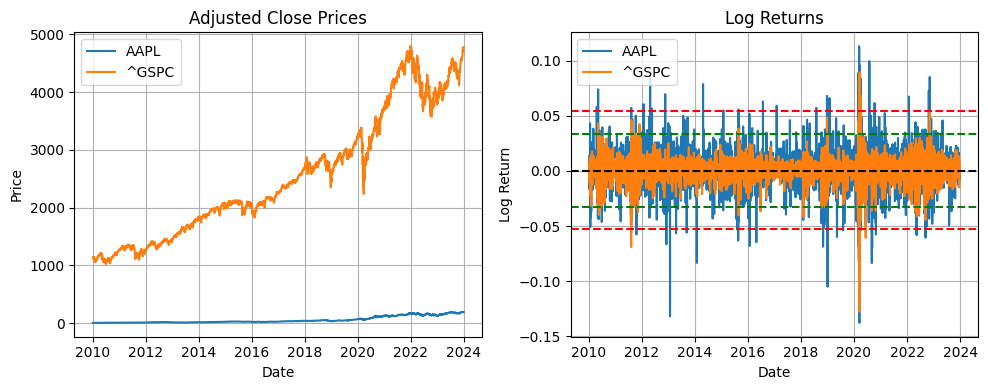

In [ ]:
log_returns = np.log(data / data.shift(1)).dropna()

mean_log_returns = log_returns.mean()
std_log_returns = log_returns.std()

upper_bound = mean_log_returns + 3 * std_log_returns
lower_bound = mean_log_returns - 3 * std_log_returns


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(data, label=[stock, market_index])
axes[0].set_title('Adjusted Close Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend(loc='upper left')
axes[0].grid(True)

axes[1].plot(log_returns, label=[stock, market_index])
axes[1].set_title('Log Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Return')
axes[1].legend(loc='upper left')
axes[1].grid(True)
axes[1].axhline(0, color='black', linestyle='--')

axes[1].axhline(upper_bound[stock], color='red', linestyle='--', label='Upper Bound (3-sigma)')
axes[1].axhline(lower_bound[stock], color='red', linestyle='--', label='Lower Bound (3-sigma)')
axes[1].axhline(upper_bound[market_index], color='green', linestyle='--', label='Upper Bound (3-sigma)')
axes[1].axhline(lower_bound[market_index], color='green', linestyle='--', label='Lower Bound (3-sigma)')

plt.tight_layout()
plt.show()

## **Table 2. Six-sigma principle for outlier detection**

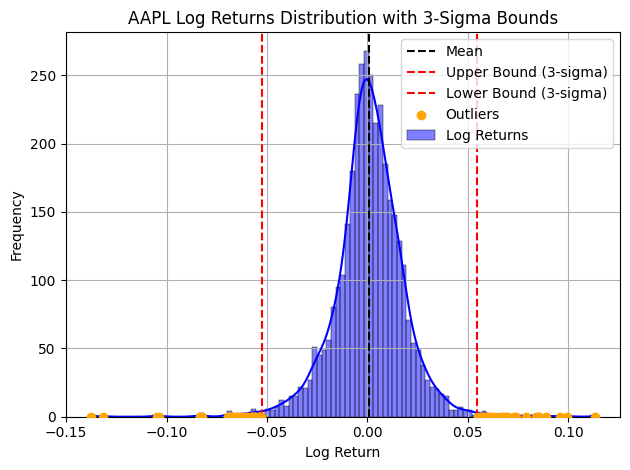

In [ ]:
aapl_log_returns = log_returns[stock]
outliers = aapl_log_returns[(aapl_log_returns > upper_bound[stock]) | (aapl_log_returns < lower_bound[stock])]

sns.histplot(aapl_log_returns, kde=True, color='blue', label='Log Returns')

plt.axvline(mean_log_returns[stock], color='black', linestyle='--', label='Mean')
plt.axvline(upper_bound[stock], color='red', linestyle='--', label='Upper Bound (3-sigma)')
plt.axvline(lower_bound[stock], color='red', linestyle='--', label='Lower Bound (3-sigma)')

plt.scatter(outliers, [0] * len(outliers), color='orange', label='Outliers', zorder=5)

plt.title(f'{stock} Log Returns Distribution with 3-Sigma Bounds')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Table 3. Outlier identification by using MAD**

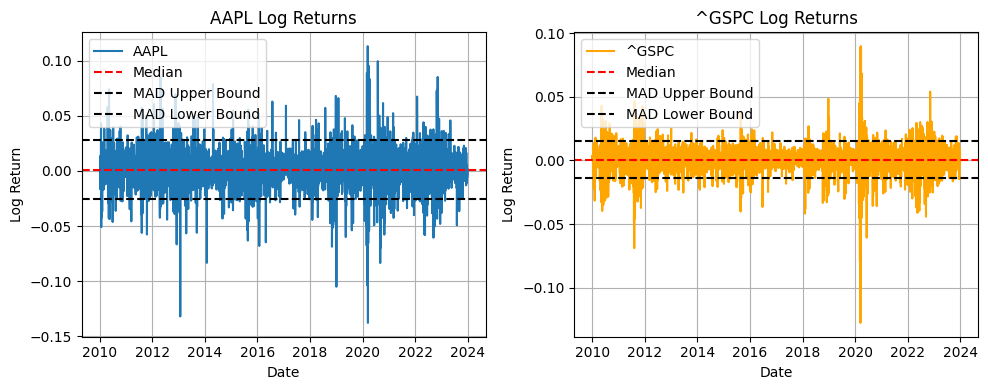

In [ ]:
median = log_returns.median()
mad = (log_returns - log_returns.median()).abs().median()

stock_log_returns = log_returns[stock]
market_log_returns = log_returns[market_index]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(stock_log_returns, label=stock, )
axes[0].axhline(median.loc[stock], color='red', linestyle='--', label='Median')
axes[0].axhline(median.loc[stock] + 3 * mad.loc[stock], color='k', linestyle='--', label='MAD Upper Bound')
axes[0].axhline(median.loc[stock] - 3 * mad.loc[stock], color='k', linestyle='--', label='MAD Lower Bound')
axes[0].set_title(f'{stock} Log Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Log Return')
axes[0].legend(loc='upper left')
axes[0].grid(True)

axes[1].plot(market_log_returns, label=market_index, color='orange')
axes[1].axhline(median.loc[market_index], color='red', linestyle='--', label='Median')
axes[1].axhline(median.loc[market_index] + 3 * mad.loc[market_index], color='k', linestyle='--', label='MAD Upper Bound')
axes[1].axhline(median.loc[market_index] - 3 * mad.loc[market_index], color='k', linestyle='--', label='MAD Lower Bound')
axes[1].set_title(f'{market_index} Log Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Return')
axes[1].legend(loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## **Table 4. Outlier removal using kMAD**

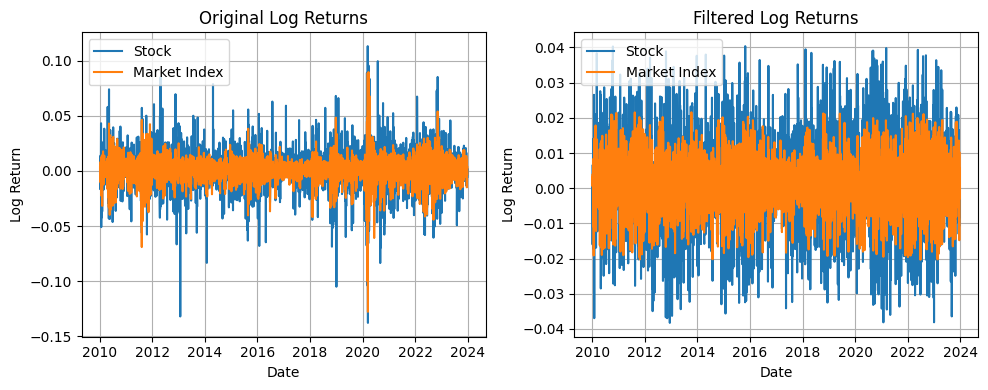

In [ ]:
k = 1.4826
sigma = k * mad

lower_bound = median - 3 * sigma
upper_bound = median + 3 * sigma

log_returns_filtered = log_returns[(log_returns >= lower_bound).all(axis=1) & (log_returns <= upper_bound).all(axis=1)]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(log_returns, label=['Stock', 'Market Index'])
axes[0].set_title('Original Log Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Log Return')
axes[0].legend(loc='upper left')
axes[0].grid(True)

axes[1].plot(log_returns_filtered, label=['Stock', 'Market Index'])
axes[1].set_title('Filtered Log Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Return')
axes[1].legend(loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
log_returns_filtered

Ticker          AAPL     ^GSPC
Date                          
2010-01-05  0.001727  0.003111
2010-01-06 -0.016034  0.000545
2010-01-07 -0.001850  0.003993
2010-01-08  0.006626  0.002878
2010-01-11 -0.008861  0.001745
...              ...       ...
2023-12-22 -0.005563  0.001659
2023-12-26 -0.002845  0.004223
2023-12-27  0.000518  0.001429
2023-12-28  0.002224  0.000370
2023-12-29 -0.005439 -0.002830

[3262 rows x 2 columns]

## **Table 5. Linear model fit (Ordinary Least Square)**

In [ ]:
y = log_returns_filtered['AAPL']
X = log_returns_filtered['^GSPC']

X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()

alpha, beta = ols_model.params
std_error = ols_model.bse
r_squared = ols_model.rsquared

conf_int = ols_model.conf_int()

sigma = np.std(ols_model.resid)

results_df = pd.DataFrame({
    'Metric': ['Alpha (Intercept)', 'Beta (Slope)', 'Sigma (Residual Standard Deviation)',
               'Standard Error for Alpha', 'Standard Error for Beta', 'R-squared',
               'Confidence Interval for Alpha (Lower)', 'Confidence Interval for Alpha (Upper)',
               'Confidence Interval for Beta (Lower)', 'Confidence Interval for Beta (Upper)'],
    'Value': [alpha, beta, sigma, std_error.iloc[0], std_error.iloc[1], r_squared,
              conf_int.iloc[0, 0], conf_int.iloc[0, 1], conf_int.iloc[1, 0], conf_int.iloc[1, 1]]})

print(tabulate(results_df, headers='keys', tablefmt='fancy_grid'))

‚ïí‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ    ‚îÇ Metric                                ‚îÇ       Value ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ  0 ‚îÇ Alpha (Intercept)                     ‚îÇ 0.000535428 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ  1 ‚îÇ Beta (Slope)                          ‚îÇ 1.03687     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ  2 ‚îÇ Sigma (Residual Standard Deviation)   ‚îÇ 0.0107727   ‚îÇ


## **Table 6. Line fit and distribution plots**

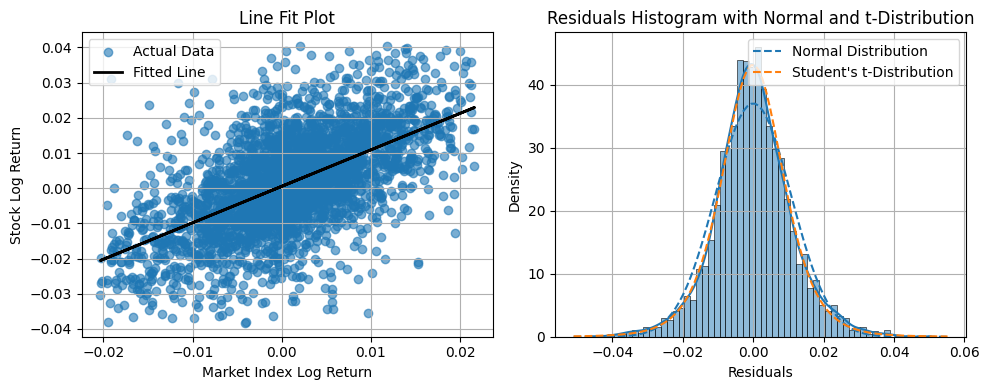

In [ ]:
y_fitted = ols_model.fittedvalues
residuals = ols_model.resid

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X['^GSPC'], y, label='Actual Data', alpha=0.6)
axes[0].plot(X['^GSPC'], y_fitted, color='k', label='Fitted Line', linewidth=2)
axes[0].set_title('Line Fit Plot')
axes[0].set_xlabel('Market Index Log Return')
axes[0].set_ylabel('Stock Log Return')
axes[0].legend(loc='upper left')
axes[0].grid(True)

sns.histplot(residuals, kde=True, ax=axes[1], stat='density')

xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
normal_pdf = norm.pdf(x, loc=residuals.mean(), scale=residuals.std())
axes[1].plot(x, normal_pdf, label='Normal Distribution', linestyle='--')

# Fit Student's t-distribution to residuals and get parameters
params = ss.t.fit(residuals)
t_pdf = t.pdf(x, *params)
axes[1].plot(x, t_pdf, label="Student's t-Distribution", linestyle='--')

axes[1].set_title('Residuals Histogram with Normal and t-Distribution')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].legend(loc='upper right')
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
params[0]

5.888366458775169

## **Table 7. OLS Rolling alpha and beta**

In [ ]:
y = log_returns_filtered['AAPL']
X = log_returns_filtered['^GSPC']

train_size = int(0.7 * len(y))
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

test_data = pd.DataFrame({'y': y_test, 'X': X_test})

window_size = 50
rolling_alpha = []
rolling_beta = []
rolling_std_err = []

for start in range(len(test_data) - window_size + 1):
    window_data = test_data.iloc[start:start + window_size]
    X_ols = add_constant(window_data['X'])
    y_ols = window_data['y']
    model = OLS(y_ols, X_ols).fit()
    rolling_alpha.append(model.params['const'])
    rolling_beta.append(model.params['X'])
    rolling_std_err.append(model.bse['X'])

rolling_alpha = pd.Series(rolling_alpha, index=test_data.index[window_size - 1:])
rolling_beta = pd.Series(rolling_beta, index=test_data.index[window_size - 1:])
rolling_std_err = pd.Series(rolling_std_err, index=test_data.index[window_size - 1:])

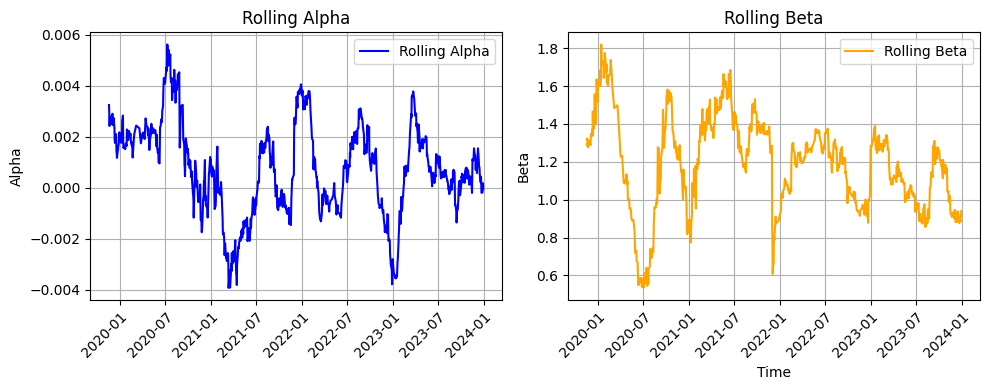

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(rolling_alpha, label='Rolling Alpha', color='blue')
axes[0].set_title('Rolling Alpha')
axes[0].set_ylabel('Alpha')
axes[0].legend()
axes[0].grid()
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-axis labels

axes[1].plot(rolling_beta, label='Rolling Beta', color='orange')
axes[1].set_title('Rolling Beta')
axes[1].set_ylabel('Beta')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].grid()
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-axis labels
plt.tight_layout()
plt.show()

## **Table 8. Kalman Filter implementation to estimate Œ± (intercept) and Œ≤ (slope)**

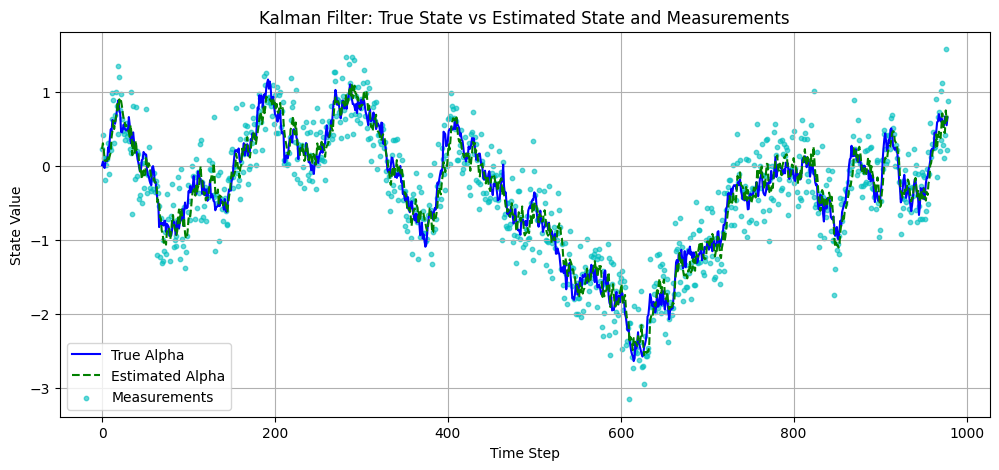

In [ ]:
sigma_alpha2 = 0.01
sigma_beta2 = 0.01
sigma_epsilon2 = 0.1

Q_k = np.array([[sigma_alpha2, 0], [0, sigma_beta2]])
R = sigma_epsilon2

x_hat = np.array([0, 0])
P = np.eye(2) * 1000
F_k = np.eye(2)

x_true = np.array([0, 0])
true_states = []
measurements = []
state_estimates = []

for k in range(len(y_test)):
    process_noise = np.random.multivariate_normal(mean=[0, 0], cov=Q_k)
    x_true = F_k @ x_true + process_noise

    measurement_noise = np.random.normal(0, np.sqrt(R))
    z = x_true[0] + x_true[1] * X_test.iloc[k] + measurement_noise

    true_states.append(x_true.copy())
    measurements.append(z)

    H_k = np.array([[1, X_test.iloc[k]]])

    x_hat_pred = F_k @ x_hat
    P_pred = F_k @ P @ F_k.T + Q_k

    K_k = P_pred @ H_k.T @ np.linalg.inv(H_k @ P_pred @ H_k.T + R)
    x_hat = x_hat_pred + K_k @ (z - H_k @ x_hat_pred)
    P = (np.eye(2) - K_k @ H_k) @ P_pred

    state_estimates.append(x_hat.copy())

true_states = np.array(true_states)
measurements = np.array(measurements)
state_estimates = np.array(state_estimates)

plt.figure(figsize=(12,5))
plt.plot(true_states[:, 0], label="True Alpha", linestyle='-', color='blue')
plt.plot(state_estimates[:, 0], label="Estimated Alpha", linestyle='--', color='green')
plt.scatter(range(len(measurements)), measurements, label="Measurements", color='c', alpha=0.6, s=10)
plt.xlabel("Time Step")
plt.ylabel("State Value")
plt.title("Kalman Filter: True State vs Estimated State and Measurements")
plt.legend()
plt.grid()
plt.show()

## **Table 9. Compare rolling OLS and Kalman Filter estimates: ùõº (intercept) and Œ≤ (slope) over time**

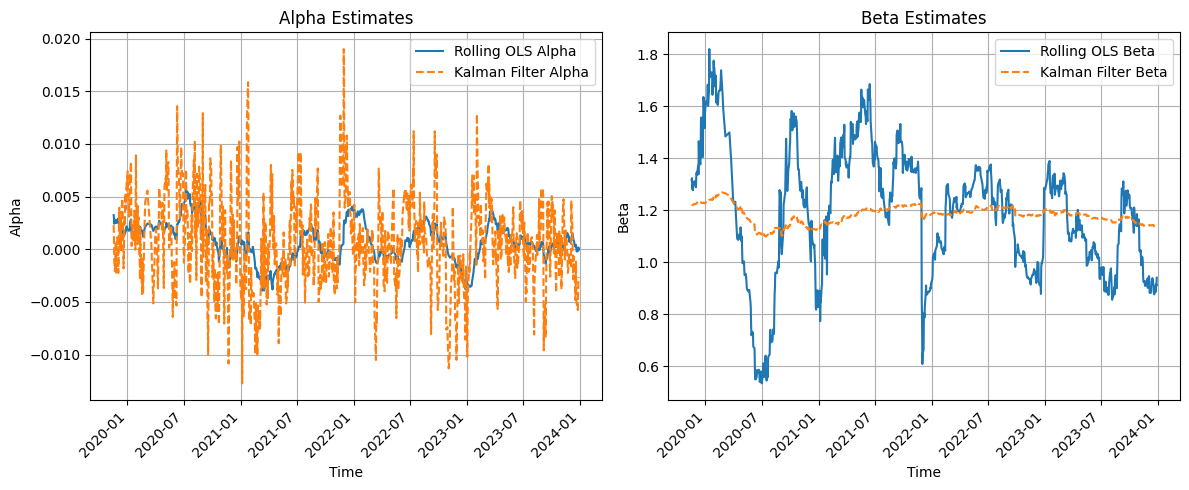

In [ ]:
state_estimates = []
for k in range(len(y)):
    H_k = np.array([[1, X.iloc[k]]])

    x_hat_pred = F_k @ x_hat
    P_pred = F_k @ P @ F_k.T + Q_k

    K_k = P_pred @ H_k.T @ np.linalg.inv(H_k @ P_pred @ H_k.T + R)
    x_hat = x_hat_pred + K_k @ (y.iloc[k] - H_k @ x_hat_pred)
    P = (np.eye(2) - K_k @ H_k) @ P_pred

    state_estimates.append(x_hat)

state_estimates = np.array(state_estimates)

kalman_alpha = state_estimates[:, 0]
kalman_beta = state_estimates[:, 1]

rolling_index = rolling_alpha.index
kalman_alpha_series = pd.Series(kalman_alpha[-len(rolling_index):], index=rolling_index)
kalman_beta_series = pd.Series(kalman_beta[-len(rolling_index):], index=rolling_index)


plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(rolling_index, rolling_alpha, label='Rolling OLS Alpha')
plt.plot(rolling_index, kalman_alpha_series, label='Kalman Filter Alpha', linestyle='--')
plt.title('Alpha Estimates')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rolling_index, rolling_beta, label='Rolling OLS Beta')
plt.plot(rolling_index, kalman_beta_series, label='Kalman Filter Beta', linestyle='--')
plt.title('Beta Estimates')
plt.xlabel('Time')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Beta')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## **Table 10. 	Parameter optimization for Kalman Filter using the Negative Log-Likelihood (NLL) as the objective function**

In [ ]:
def negative_log_likelihood(params, y, X):
    sigma_alpha2, sigma_beta2, sigma_epsilon2 = params
    Q_k = np.diag([sigma_alpha2, sigma_beta2])
    R = sigma_epsilon2
    F_k = np.eye(2)

    x_hat = np.zeros(2)
    P = np.eye(2) * 1000

    nll = 0
    for y_k, X_k in zip(y, X):
        H_k = np.array([[1, X_k]])
        x_hat_pred = F_k @ x_hat
        P_pred = F_k @ P @ F_k.T + Q_k

        S = H_k @ P_pred @ H_k.T + R
        residual = y_k - H_k @ x_hat_pred

        nll += 0.5 * (np.log(np.linalg.det(S)) + residual.T @ np.linalg.inv(S) @ residual)

        K_k = P_pred @ H_k.T @ np.linalg.inv(S)
        x_hat = x_hat_pred + K_k.flatten() * residual
        P = (np.eye(2) - K_k @ H_k) @ P_pred

    return nll

initial_params = [0.01, 0.01, 0.1]
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(y_train.values, X_train.values),
    bounds=[(1e-6, None), (1e-6, None), (1e-6, None)])
sigma_alpha2_cal, sigma_beta2_cal, sigma_epsilon2_cal = result.x
print("Calibrated Parameters:")
print(f"sigma_alpha2: {sigma_alpha2_cal}")
print(f"sigma_beta2: {sigma_beta2_cal}")
print(f"sigma_epsilon2: {sigma_epsilon2_cal}")

Calibrated Parameters:
sigma_alpha2: 1e-06
sigma_beta2: 0.0004705353410134443
sigma_epsilon2: 0.00010949294465135099


## **Table 11. Beta estimates obtained from Rolling OLS and Kalman Filter over time**

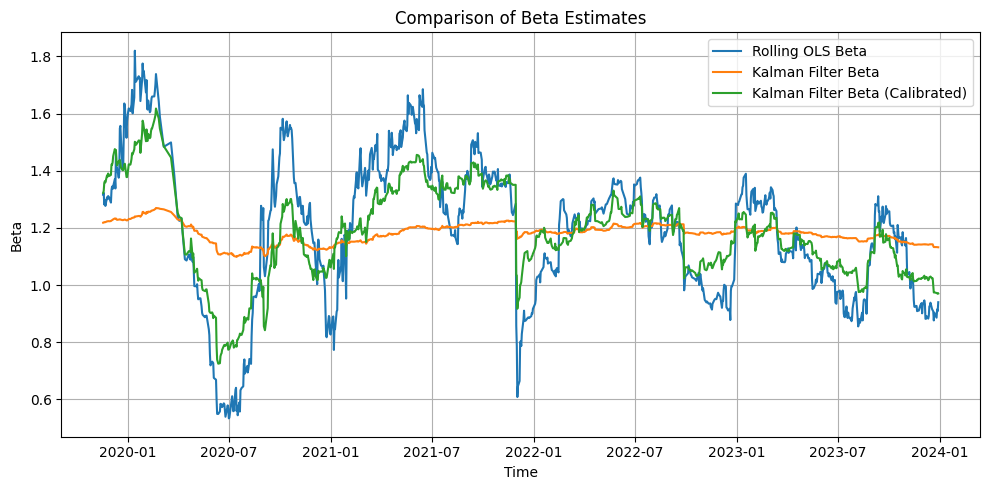

In [ ]:
def kalman_filter(y, X, sigma_alpha2, sigma_beta2, sigma_epsilon2):
    Q_k = np.diag([sigma_alpha2, sigma_beta2])
    R = sigma_epsilon2
    F_k = np.eye(2)

    # Initial state and covariance
    x_hat = np.zeros(2)
    P = np.eye(2) * 1000

    state_estimates = []

    for y_k, X_k in zip(y, X):
        H_k = np.array([[1, X_k]])  #

        # Prediction step
        x_hat_pred = F_k @ x_hat
        P_pred = F_k @ P @ F_k.T + Q_k

        # Update step
        S = H_k @ P_pred @ H_k.T + R
        K_k = P_pred @ H_k.T @ np.linalg.inv(S)
        x_hat = x_hat_pred + K_k.flatten() * (y_k - H_k @ x_hat_pred)
        P = (np.eye(2) - K_k @ H_k) @ P_pred

        state_estimates.append(x_hat)

    return np.array(state_estimates)

state_estimates_train = kalman_filter(
    y_train.values, X_train.values, sigma_alpha2_cal, sigma_beta2_cal, sigma_epsilon2_cal)
state_estimates_test = kalman_filter(
    y_test.values, X_test.values, sigma_alpha2_cal, sigma_beta2_cal, sigma_epsilon2_cal)

kalman_alpha_test = state_estimates_test[:, 0]
kalman_beta_test = state_estimates_test[:, 1]

rolling_index = rolling_alpha.index
kalman_beta_series_test = pd.Series(kalman_beta_test[-len(rolling_index):], index=rolling_index)

plt.figure(figsize=(10, 5))
plt.plot(rolling_index, rolling_beta, label="Rolling OLS Beta")
plt.plot(rolling_index, kalman_beta_series, label='Kalman Filter Beta')
plt.plot(rolling_index, kalman_beta_series_test, label="Kalman Filter Beta (Calibrated)")
plt.title("Comparison of Beta Estimates")
plt.xlabel("Time")
plt.ylabel("Beta")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## **Table 12. Error estimation**

In [ ]:
error_data = pd.DataFrame({
    'AAPL': y_test.values[-len(rolling_index):],
    '^GSPC': X_test.values[-len(rolling_index):],
    'ols_beta': rolling_beta.values,
    'ols_std_err': np.std(rolling_beta.values - kalman_beta_series_test.values),
    'ols_alpha': rolling_alpha.values,
    'Kalman_beta': kalman_beta_series_test.values,
    'Kalman_err': rolling_beta.values - kalman_beta_series_test.values})

print(tabulate(error_data.head(), headers='keys', tablefmt='fancy_grid'))

‚ïí‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ    ‚îÇ         AAPL ‚îÇ        ^GSPC ‚îÇ   ols_beta ‚îÇ   ols_std_err ‚îÇ   ols_alpha ‚îÇ   Kalman_beta ‚îÇ   Kalman_err ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ  0 ‚îÇ  0.00502946  ‚îÇ  0.000503026 ‚îÇ    1.3163  ‚îÇ       0.12441 ‚îÇ  0.0032374  ‚îÇ       1.32266 ‚îÇ  -0.00635932 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

## **Table 13. Error visualization**

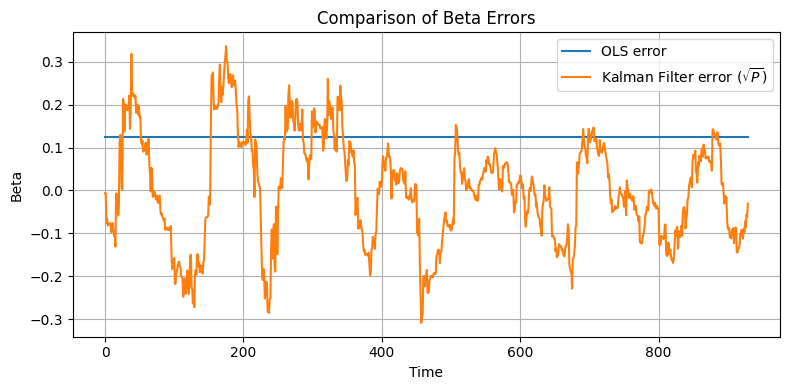

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(error_data['ols_std_err'], label="OLS error")
plt.plot(error_data['Kalman_err'], label="Kalman Filter error ($\sqrt{P}$)")
plt.title("Comparison of Beta Errors")
plt.xlabel("Time")
plt.ylabel("Beta")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## **Table 14. Additional metrics**

R^2 for Rolling OLS: 0.4886
R^2 for Kalman Filter: 0.5534


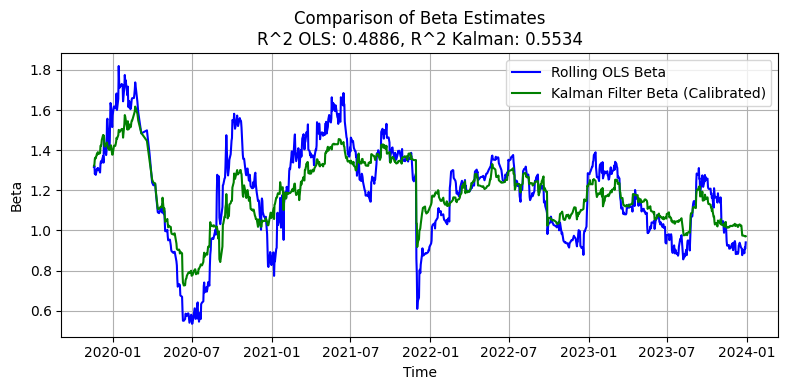

In [ ]:
state_estimates_calibrated = kalman_filter(
    y_test.values, X_test.values, sigma_alpha2_cal, sigma_beta2_cal, sigma_epsilon2_cal)

state_estimates_train = kalman_filter(
    y_train.values, X_train.values, sigma_alpha2_cal, sigma_beta2_cal, sigma_epsilon2_cal)
state_estimates_test = kalman_filter(
    y_test.values, X_test.values, sigma_alpha2_cal, sigma_beta2_cal, sigma_epsilon2_cal)

kalman_alpha_calibrated = state_estimates_calibrated[:, 0]
kalman_beta_calibrated = state_estimates_calibrated[:, 1]

rolling_index = rolling_beta.index
kalman_beta_series_test = pd.Series(kalman_beta_calibrated[-len(rolling_index):], index=rolling_index)

aligned_y_test = y_test.values[-len(rolling_index):]
aligned_X_test = X_test.values[-len(rolling_index):]

SS_tot = np.sum((aligned_y_test - np.mean(aligned_y_test)) ** 2)
SS_res_ols = np.sum((aligned_y_test - (rolling_alpha.values + rolling_beta.values * aligned_X_test)) ** 2)
SS_res_kalman = np.sum((aligned_y_test - (kalman_alpha_calibrated[-len(rolling_index):] + kalman_beta_calibrated[-len(rolling_index):] * aligned_X_test)) ** 2)  # Use aligned data

r2_ols = 1 - SS_res_ols / SS_tot
r2_kalman = 1 - SS_res_kalman / SS_tot

mse_ols = np.mean((aligned_y_test - (rolling_alpha.values + rolling_beta.values * aligned_X_test)) ** 2)
mse_kalman = np.mean((aligned_y_test - (kalman_alpha_calibrated[-len(rolling_index):] + kalman_beta_calibrated[-len(rolling_index):] * aligned_X_test)) ** 2)

mae_ols = np.mean(np.abs(aligned_y_test - (rolling_alpha.values + rolling_beta.values * aligned_X_test)))
mae_kalman = np.mean(np.abs(aligned_y_test - (kalman_alpha_calibrated[-len(rolling_index):] + kalman_beta_calibrated[-len(rolling_index):] * aligned_X_test)))

print(f"R^2 for Rolling OLS: {r2_ols:.4f}")
print(f"R^2 for Kalman Filter: {r2_kalman:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(rolling_index, rolling_beta, label="Rolling OLS Beta", color="blue")
plt.plot(rolling_index, kalman_beta_series_test, label="Kalman Filter Beta (Calibrated)", color="green")
plt.title(f"Comparison of Beta Estimates\nR^2 OLS: {r2_ols:.4f}, R^2 Kalman: {r2_kalman:.4f}")
plt.xlabel("Time")
plt.ylabel("Beta")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(f"MSE for Rolling OLS: {mse_ols:.4f}")
print(f"MSE for Kalman Filter: {mse_kalman:.4f}")
print(f"MAE for Rolling OLS: {mae_ols:.4f}")
print(f"MAE for Kalman Filter: {mae_kalman:.4f}")

MSE for Rolling OLS: 0.0001
MSE for Kalman Filter: 0.0001
MAE for Rolling OLS: 0.0077
MAE for Kalman Filter: 0.0072


## **Table 15. Trading strategy with Z-Score and trade signals generation**

[*********************100%***********************]  2 of 2 completed


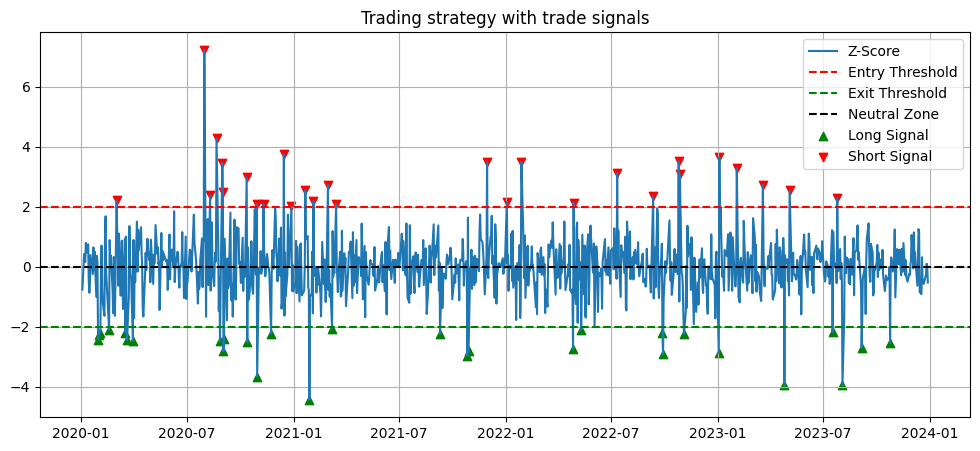

In [ ]:
def kalman_filter(y, X, sigma_alpha2, sigma_beta2, sigma_epsilon2):
    Q_k = np.diag([sigma_alpha2, sigma_beta2])
    R = sigma_epsilon2
    F_k = np.eye(2)

    # Initial state and covariance
    x_hat = np.zeros(2)
    P = np.eye(2) * 1000

    state_estimates = []

    for y_k, X_k in zip(y, X):
        H_k = np.array([[1, X_k]])

        # Prediction step
        x_hat_pred = F_k @ x_hat
        P_pred = F_k @ P @ F_k.T + Q_k

        # Update step
        S = H_k @ P_pred @ H_k.T + R
        K_k = P_pred @ H_k.T @ np.linalg.inv(S)
        x_hat = x_hat_pred + K_k.flatten() * (y_k - H_k @ x_hat_pred)
        P = (np.eye(2) - K_k @ H_k) @ P_pred

        state_estimates.append(x_hat)

    return np.array(state_estimates)

def kalman_calibration(y, X):
    def loss(params):
        sigma_alpha2, sigma_beta2, sigma_epsilon2 = params
        states = kalman_filter(y, X, sigma_alpha2, sigma_beta2, sigma_epsilon2)
        alpha, beta = states[:, 0], states[:, 1]
        residuals = y - (alpha + beta * X)
        return np.mean(residuals ** 2)

    # Initial guesses for the parameters
    initial_guess = [1e-4, 1e-4, 1e-4]
    bounds = [(1e-8, 1), (1e-8, 1), (1e-8, 1)]

    result = minimize(loss, initial_guess, bounds=bounds, method = 'L-BFGS-B')
    return result.x

start_date = "2020-01-01"
end_date = "2023-12-31"
stocks = ['AAPL', 'MSFT']
data = yf.download(stocks, start=start_date, end = end_date)['Adj Close']
log_returns = np.log(data / data.shift(1)).dropna()

# Calibrate Kalman filter
sigma_alpha2_cal, sigma_beta2_cal, sigma_epsilon2_cal = kalman_calibration(
    log_returns['AAPL'].values, log_returns['MSFT'].values)

# Kalman filter to estimate hedge ratios
state_estimates = kalman_filter(
    log_returns['AAPL'].values, log_returns['MSFT'].values,
    sigma_alpha2_cal, sigma_beta2_cal, sigma_epsilon2_cal)
hedge_ratios = state_estimates[:, 1]

# Trading strategy
log_returns['Hedge Ratio'] = hedge_ratios
log_returns['Spread'] = log_returns['AAPL'] - log_returns['Hedge Ratio'] * log_returns['MSFT']

spread_mean = log_returns['Spread'].mean()
spread_std = log_returns['Spread'].std()
log_returns['Z-Score'] = (log_returns['Spread'] - spread_mean) / spread_std

# Generate buy/sell signals based on Z-score
entry_threshold = 2.0
exit_threshold = 0.0

log_returns['Long Signal'] = log_returns['Z-Score'] < -entry_threshold
log_returns['Short Signal'] = log_returns['Z-Score'] > entry_threshold
log_returns['Exit Signal'] = abs(log_returns['Z-Score']) < exit_threshold

plt.figure(figsize=(12, 5))
plt.plot(log_returns.index, log_returns['Z-Score'], label = "Z-Score")
plt.axhline(entry_threshold, color = "red", linestyle = "--", label = "Entry Threshold")
plt.axhline(-entry_threshold, color = "green", linestyle = "--", label = "Exit Threshold")
plt.axhline(exit_threshold, color = "black", linestyle = "--", label = "Neutral Zone")

long_signal_index = log_returns.index[log_returns['Long Signal']]
short_signal_index = log_returns.index[log_returns['Short Signal']]

plt.scatter(long_signal_index,
            log_returns['Z-Score'][log_returns['Long Signal']],
            color = "green",
            label = "Long Signal",
            marker = "^")
plt.scatter(short_signal_index,
            log_returns['Z-Score'][log_returns['Short Signal']],
            color = "red",
            label = "Short Signal",
            marker = "v")

plt.title("Trading strategy with trade signals")
plt.legend()
plt.grid()
plt.show()

## **Table 16. Back testing and return estimation from trade signals**

In [ ]:
log_returns['Position_1'] = 0
log_returns['Position_2'] = 0
buy_count = 0
sell_count = 0

for i in range(len(log_returns)):
    if log_returns['Z-Score'].iloc[i] < -0.1:  # Buy AAPL, Sell MSFT
        log_returns.loc[log_returns.index[i], 'Position_1'] = 1
        log_returns.loc[log_returns.index[i], 'Position_2'] = -round(log_returns['Hedge Ratio'].iloc[i], 0)
        buy_count += 1  # Increment buy count
    elif log_returns['Z-Score'].iloc[i] > 0.1:  # Sell AAPL, Buy MSFT
        log_returns.loc[log_returns.index[i], 'Position_1'] = -1
        log_returns.loc[log_returns.index[i], 'Position_2'] = round(log_returns['Hedge Ratio'].iloc[i], 0)
        sell_count += 1  # Increment sell count
    elif -0.1 < log_returns['Z-Score'].iloc[i] < 0.1:  # Liquidate
        log_returns.loc[log_returns.index[i], ['Position_1', 'Position_2']] = 0

log_returns['AAPL Returns'] = log_returns['AAPL'] * log_returns['Position_1'].shift(1)
log_returns['MSFT Returns'] = log_returns['MSFT'] * log_returns['Position_2'].shift(1)

log_returns['Strategy Returns'] = log_returns['AAPL Returns'] + log_returns['MSFT Returns']
total_returns = log_returns['Strategy Returns'].sum()

print("Total Buy Signals:", buy_count)
print("Total Sell Signals:", sell_count)
print("Total Returns:", total_returns)

Total Buy Signals: 450
Total Sell Signals: 450
Total Returns: 0.01671563547404953


## **Table 18. 	Inflation and Unemployment Data ingestion from Federal Reserve Economic Data (FRED, USA) and visualization**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

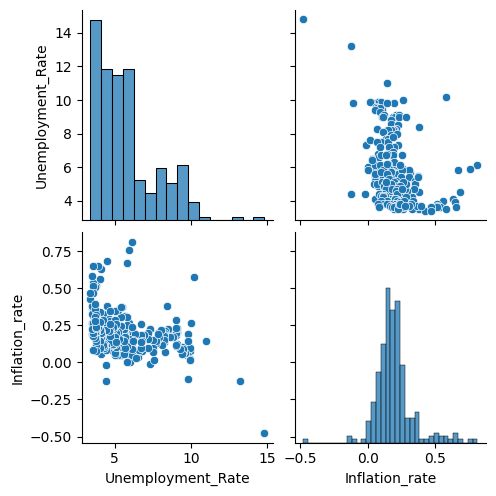

In [ ]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2024,1,1)

inflation = pdr.get_data_fred('CPILFESL', start=start, end=end)
inflation_rate = inflation.pct_change() * 100
inflation_rate.reset_index(inplace=True)

unemployment_rate = pdr.get_data_fred('UNRATE', start=start, end=end)
unemployment_rate.reset_index(inplace=True)

data = pd.DataFrame({
    'Unemployment_Rate': unemployment_rate["UNRATE"],
    'Inflation_rate': inflation_rate['CPILFESL'] })

data = data.set_index(inflation_rate['DATE'])
data.dropna(inplace=True)
sns.pairplot(data)
plt.show()

## **Table 19.  Lowess curve to visualize the relationship**

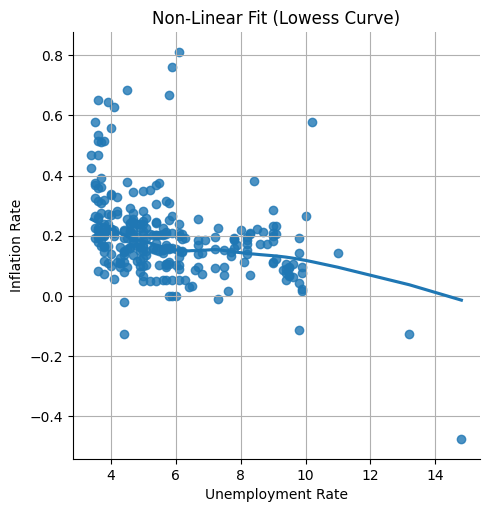

In [ ]:
sns.lmplot(x='Unemployment_Rate', y='Inflation_rate', data=data, lowess=True)
plt.title("Non-Linear Fit (Lowess Curve)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Inflation Rate")
plt.grid()
plt.show()

## **Table 20. UKF implementation**

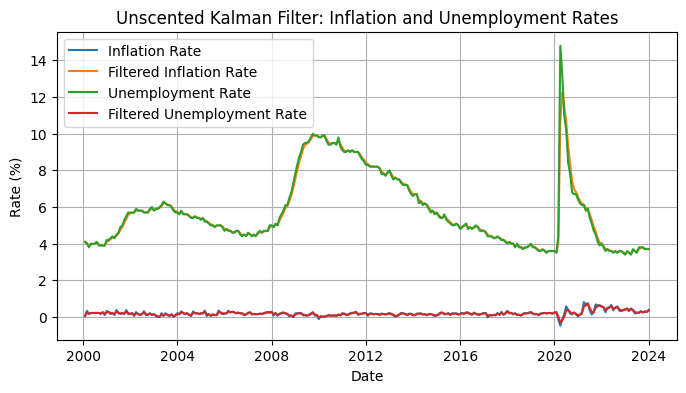

In [ ]:
observations = data.to_numpy()

def state_transition(state, noise):
    inflation, unemployment = state
    inflation_new = inflation + noise[0]
    unemployment_new = unemployment + noise[1]
    return np.array([inflation_new, unemployment_new])

def observation_function(state, noise):
    inflation, unemployment = state
    inflation_obs = inflation + noise[0]
    unemployment_obs = unemployment + noise[1]
    return np.array([inflation_obs, unemployment_obs])

ukf = UnscentedKalmanFilter(
    transition_functions=state_transition,
    observation_functions=observation_function,
    transition_covariance=np.eye(2) * 0.5 + np.eye(2) * 1e-6,
    observation_covariance=np.eye(2) * 0.5 + np.eye(2) * 1e-6,
    initial_state_mean=np.array([observations[0, 0], observations[0, 1]]),
    initial_state_covariance=np.eye(2) * 0.5 + np.eye(2) * 1e-6)

filtered_states, _ = ukf.filter(observations)
filtered_df = pd.DataFrame(
    filtered_states, columns=["Filtered_Inflation", "Filtered_Unemployment"], index=data.index)

plt.figure(figsize=(8, 4))
plt.plot(data.index, data['Inflation_rate'], label="Inflation Rate")
plt.plot(filtered_df.index, filtered_df["Filtered_Inflation"], label="Filtered Inflation Rate")
plt.plot(data.index, data['Unemployment_Rate'], label="Unemployment Rate")
plt.plot(filtered_df.index, filtered_df["Filtered_Unemployment"], label="Filtered Unemployment Rate")
plt.legend()
plt.title("Unscented Kalman Filter: Inflation and Unemployment Rates")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.grid()
plt.show()

## **Table 21. Comparison of Data Distributions: Original vs. Filtered (UKF) Inflation and Unemployment Rates**

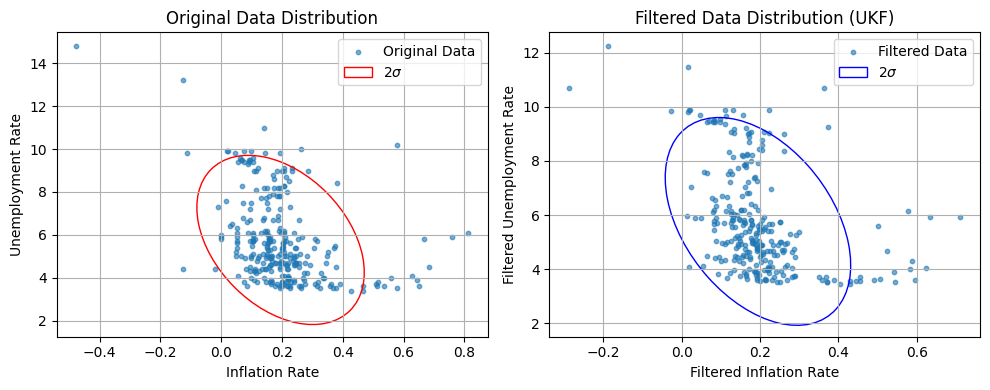

In [ ]:
def confidence_ellipse(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# State transition and observation functions for UKF
def state_transition(state, noise):
    inflation, unemployment = state
    inflation_new = inflation + noise[0]
    unemployment_new = unemployment + noise[1]
    return np.array([inflation_new, unemployment_new])

def observation_function(state, noise):
    inflation, unemployment = state
    inflation_obs = inflation + noise[0]
    unemployment_obs = unemployment + noise[1]
    return np.array([inflation_obs, unemployment_obs])

observations = data.to_numpy()

ukf = UnscentedKalmanFilter(
    transition_functions=state_transition,
    observation_functions=observation_function,
    transition_covariance=np.eye(2) * 0.5 + np.eye(2) * 1e-6,
    observation_covariance=np.eye(2) * 0.5 + np.eye(2) * 1e-6,
    initial_state_mean=np.array([observations[0, 0], observations[0, 1]]),
    initial_state_covariance=np.eye(2) * 0.5 + np.eye(2) * 1e-6)

filtered_states, _ = ukf.filter(observations)
filtered_df = pd.DataFrame(filtered_states, columns=["Filtered_Inflation", "Filtered_Unemployment"], index=data.index)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

mean_original = np.mean(observations, axis=0)
cov_original = np.cov(observations, rowvar=False)
ax1.scatter(data['Inflation_rate'], data['Unemployment_Rate'], s=10, alpha=0.6, label="Original Data")
confidence_ellipse(mean_original, cov_original, ax1, n_std=2, edgecolor='red', label=r'$2\sigma$')

ax1.set_xlabel('Inflation Rate')
ax1.set_ylabel('Unemployment Rate')
ax1.set_title('Original Data Distribution')
ax1.legend()
ax1.grid()

mean_filtered = np.mean(filtered_df[['Filtered_Inflation', 'Filtered_Unemployment']].values, axis=0)
cov_filtered = np.cov(filtered_df[['Filtered_Inflation', 'Filtered_Unemployment']].values, rowvar=False)
ax2.scatter(filtered_df['Filtered_Inflation'], filtered_df['Filtered_Unemployment'], s=10, alpha=0.6, label="Filtered Data")
confidence_ellipse(mean_filtered, cov_filtered, ax2, n_std=2, edgecolor='blue', label=r'$2\sigma$')

ax2.set_xlabel('Filtered Inflation Rate')
ax2.set_ylabel('Filtered Unemployment Rate')
ax2.set_title('Filtered Data Distribution (UKF)')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()